# Libraries

In [112]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the dataset

In [113]:
from google.colab import files


uploaded = files.upload()

Saving car.data.csv to car.data (2).csv


In [114]:
careval_df = pd.read_csv('car.data.csv')
careval_df

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


In [115]:
col_name = ['buying','maint' ,'doors','persons','lug_boot','safty','class']
careval_df.columns = col_name
col_name

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safty', 'class']

In [116]:
careval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1727 non-null   object
 1   maint     1727 non-null   object
 2   doors     1727 non-null   object
 3   persons   1727 non-null   object
 4   lug_boot  1727 non-null   object
 5   safty     1727 non-null   object
 6   class     1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


# Data cleaning and preprocessing

In [117]:
encoder = OneHotEncoder()
encoder = OneHotEncoder()
encoded_careval = encoder.fit_transform(careval_df.drop(columns=['class'])).toarray()
encoded_df = pd.DataFrame(encoded_careval, columns=encoder.get_feature_names_out(careval_df.columns[:-1]))

In [118]:
print("Central Tendency Measures:")
print("Mean:\n", encoded_df.mean())
print("Median:\n", encoded_df.median())

Central Tendency Measures:
Mean:
 buying_high       0.250145
buying_low        0.250145
buying_med        0.250145
buying_vhigh      0.249566
maint_high        0.250145
maint_low         0.250145
maint_med         0.250145
maint_vhigh       0.249566
doors_2           0.249566
doors_3           0.250145
doors_4           0.250145
doors_5more       0.250145
persons_2         0.332947
persons_4         0.333526
persons_more      0.333526
lug_boot_big      0.333526
lug_boot_med      0.333526
lug_boot_small    0.332947
safty_high        0.333526
safty_low         0.332947
safty_med         0.333526
dtype: float64
Median:
 buying_high       0.0
buying_low        0.0
buying_med        0.0
buying_vhigh      0.0
maint_high        0.0
maint_low         0.0
maint_med         0.0
maint_vhigh       0.0
doors_2           0.0
doors_3           0.0
doors_4           0.0
doors_5more       0.0
persons_2         0.0
persons_4         0.0
persons_more      0.0
lug_boot_big      0.0
lug_boot_med      0.0
l

In [119]:
X = encoded_df
y = careval_df['class']
model = LogisticRegression(max_iter=10000)
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Bias-Variance Analysis - Cross-validation scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean()}")

Bias-Variance Analysis - Cross-validation scores: [0.70231214 0.84971098 0.74782609 0.75652174 0.77101449]
Mean CV Score: 0.7654770880455726


# Recursive Feature Elimination

In [120]:
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print(selected_features)

Index(['buying_high', 'buying_vhigh', 'maint_low', 'maint_med', 'maint_vhigh',
       'persons_2', 'persons_4', 'lug_boot_small', 'safty_high', 'safty_low'],
      dtype='object')


# Normalization

In [121]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[selected_features])

# Removing outliers using z-score

In [122]:
from scipy import stats
z_scores = np.abs(stats.zscore(X_scaled))
X_clean = X_scaled[(z_scores < 3).all(axis=1)]
y_clean = y[(z_scores < 3).all(axis=1)]

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Logistic Regression

In [124]:
base_model = LogisticRegression(max_iter=10000)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         acc       0.83      0.82      0.82        77
        good       0.70      0.47      0.56        15
       unacc       0.96      0.97      0.97       237
       vgood       0.63      0.71      0.67        17

    accuracy                           0.90       346
   macro avg       0.78      0.74      0.75       346
weighted avg       0.90      0.90      0.90       346



# Ensemble Techniques

In [125]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=10000)),
    ('ada', AdaBoostClassifier(n_estimators=100, random_state=42)),
    ('bagging', BaggingClassifier(base_estimator=LogisticRegression(max_iter=10000), n_estimators=100, random_state=42))
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)
print(classification_report(y_test, y_pred_stack))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

              precision    recall  f1-score   support

         acc       0.84      0.84      0.84        77
        good       0.54      0.47      0.50        15
       unacc       0.98      0.98      0.98       237
       vgood       0.63      0.71      0.67        17

    accuracy                           0.91       346
   macro avg       0.75      0.75      0.75       346
weighted avg       0.91      0.91      0.91       346



# AdaBoost

In [126]:
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
ada_accuracy = accuracy_score(y_test, y_pred_ada)
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

         acc       0.73      0.39      0.51        77
        good       0.44      0.27      0.33        15
       unacc       0.87      0.97      0.92       237
       vgood       0.59      1.00      0.74        17

    accuracy                           0.82       346
   macro avg       0.66      0.66      0.62       346
weighted avg       0.80      0.82      0.79       346



# Bagging

In [127]:
bagging_model = BaggingClassifier(base_estimator=LogisticRegression(max_iter=10000), n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)
print(classification_report(y_test, y_pred_bagging))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

         acc       0.79      0.73      0.76        77
        good       0.70      0.47      0.56        15
       unacc       0.93      0.97      0.95       237
       vgood       0.63      0.71      0.67        17

    accuracy                           0.88       346
   macro avg       0.76      0.72      0.73       346
weighted avg       0.87      0.88      0.87       346



# Random Forest

In [128]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         acc       0.85      0.90      0.87        77
        good       0.54      0.47      0.50        15
       unacc       1.00      0.98      0.99       237
       vgood       0.63      0.71      0.67        17

    accuracy                           0.92       346
   macro avg       0.75      0.76      0.76       346
weighted avg       0.93      0.92      0.93       346



# Decision Tree

In [129]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

         acc       0.85      0.90      0.87        77
        good       0.54      0.47      0.50        15
       unacc       1.00      0.98      0.99       237
       vgood       0.63      0.71      0.67        17

    accuracy                           0.92       346
   macro avg       0.75      0.76      0.76       346
weighted avg       0.93      0.92      0.93       346



# Support Vector Machine

In [130]:
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         acc       0.85      0.90      0.87        77
        good       0.54      0.47      0.50        15
       unacc       1.00      0.98      0.99       237
       vgood       0.63      0.71      0.67        17

    accuracy                           0.92       346
   macro avg       0.75      0.76      0.76       346
weighted avg       0.93      0.92      0.93       346



# Visualization

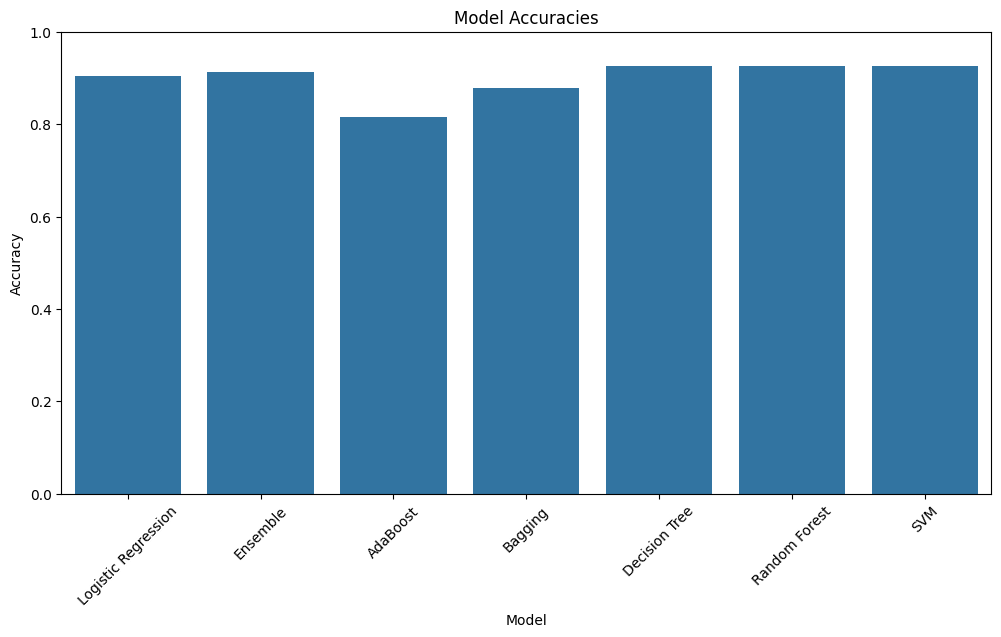

In [141]:
models = ['Logistic Regression', 'Ensemble', 'AdaBoost', 'Bagging', 'Decision Tree', 'Random Forest', 'SVM']
accuracies = [base_accuracy, stacking_accuracy, ada_accuracy, bagging_accuracy, dt_accuracy, rf_accuracy, svm_accuracy,]

plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

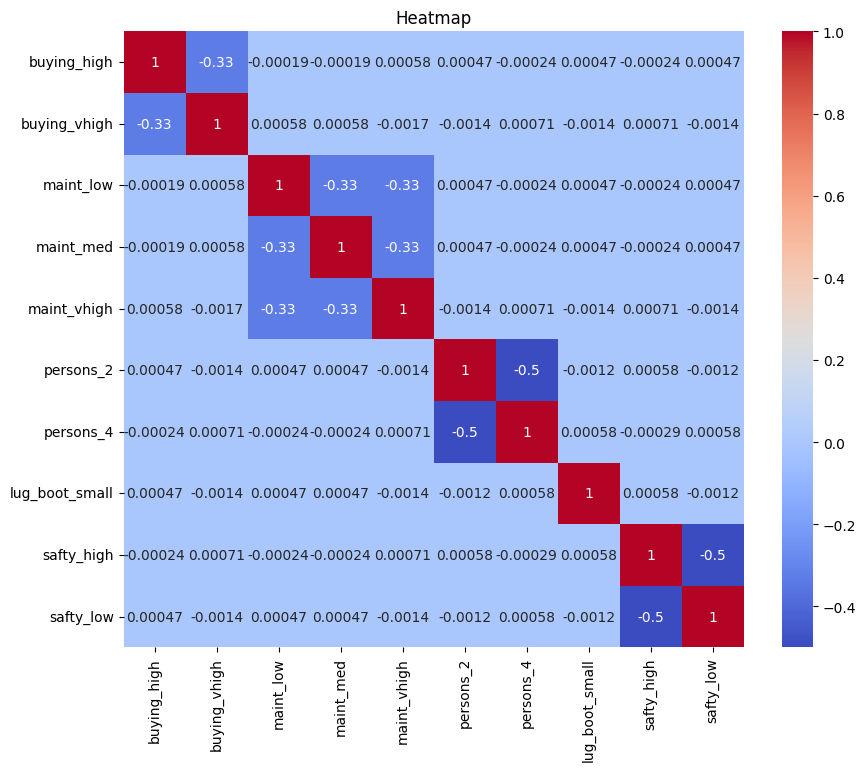

In [139]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X_scaled, columns=selected_features).corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap')
plt.show()

In [140]:
print("\nSummary of All Model Accuracies")
for model, accuracy in zip(models, accuracies):
    print(f"{model}: {accuracy:.4f}")


Summary of All Model Accuracies
Logistic Regression: 0.9046
Stacking: 0.9133
AdaBoost: 0.8150
Bagging: 0.8786
Decision Tree: 0.9249
Random Forest: 0.9249
SVM: 0.9249


# The best model is Decision Tree and Random Forest with the same result of 0.9249.